# Importing packages

In [1]:
using Plots
using XLSX
using YAML
using CSV
using DataFrames
using Statistics
using StatsBase
using Dates

# Importing data

In [2]:
# Read CSV files and convert to DataFrame
size_ARERA = "1_5_a_3"
#size_ARERA = "3_a_4_5"

# Define the file path
general_path = @__DIR__
relative_path_GSE = "../results/Dati/GSE_profiles_resident_v0_1_3_power.csv"
relative_path_GSE_2 = "../results/Dati/GSE_profiles_resident_v0_all_power.csv"
relative_path_GSE_3 = "../results/Dati/GSE_profiles_resident_v0_all_power_average.csv"
relative_path_ARERA = "../results/Dati/ARERA_profiles$size_ARERA.csv"
file_GSE= joinpath(general_path,relative_path_GSE)
file_GSE_2= joinpath(general_path,relative_path_GSE_2)
file_GSE_3= joinpath(general_path,relative_path_GSE_3)
file_ARERA= joinpath(general_path,relative_path_ARERA)

# Read data from the CSV
GSE_profiles= DataFrame(CSV.File(file_GSE))
GSE_profiles_2= DataFrame(CSV.File(file_GSE_2))
GSE_profiles_3= DataFrame(CSV.File(file_GSE_3))
ARERA_profiles= DataFrame(CSV.File(file_ARERA))

# Show first 20 rows of all four DataFrame
first(ARERA_profiles, 20)

Row,Mese,Giorno,Ora,Valore_orario
,Int64,Int64,Int64,Float64
1,1,1,1,0.1911
2,1,1,2,0.1532
3,1,1,3,0.1336
4,1,1,4,0.1252
5,1,1,5,0.1261
6,1,1,6,0.1428
7,1,1,7,0.1819
8,1,1,8,0.2371
9,1,1,9,0.2507


# Unite the dataframes

In [3]:
# Create a new dataframe with the merge of the two dataframes
df_comparison = DataFrame(Mese = Int64[], Giorno = Int64[], Ora = Int64[], GSE_1_3_power = Float64[], GSE_all_power = Float64[], GSE_all_power_average = Float64[], ARERA = Float64[])

for i in 1:size(GSE_profiles,1)
    for j in 1:size(ARERA_profiles,1)
        if GSE_profiles[i,:Mese] == ARERA_profiles[j,:Mese] && GSE_profiles[i,:Giorno] == ARERA_profiles[j,:Giorno] && GSE_profiles[i,:Ora] == (ARERA_profiles[j,:Ora] - 1)
            push!(df_comparison, [GSE_profiles[i,:Mese], GSE_profiles[i,:Giorno], GSE_profiles[i,:Ora], 
            GSE_profiles[i,:PDMM], GSE_profiles_2[i,:PDMM], GSE_profiles_3[i,:PDMM], ARERA_profiles[j,:Valore_orario]])
        end
    end
end

# Show the first 20 rows of the new DataFrame
first(df_comparison, 20)

Row,Mese,Giorno,Ora,GSE_1_3_power,GSE_all_power,GSE_all_power_average,ARERA
,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,1,1,0,0.182458,0.211819,0.179137,0.1911
2,1,1,1,0.153784,0.178531,0.150985,0.1532
3,1,1,2,0.138273,0.160524,0.135757,0.1336
4,1,1,3,0.131246,0.152367,0.128858,0.1252
5,1,1,4,0.13041,0.151395,0.128037,0.1261
6,1,1,5,0.14112,0.163829,0.138552,0.1428
7,1,1,6,0.175105,0.203283,0.171918,0.1819
8,1,1,7,0.225328,0.261588,0.221228,0.2371
9,1,1,8,0.241062,0.279853,0.236675,0.2507


# Plot

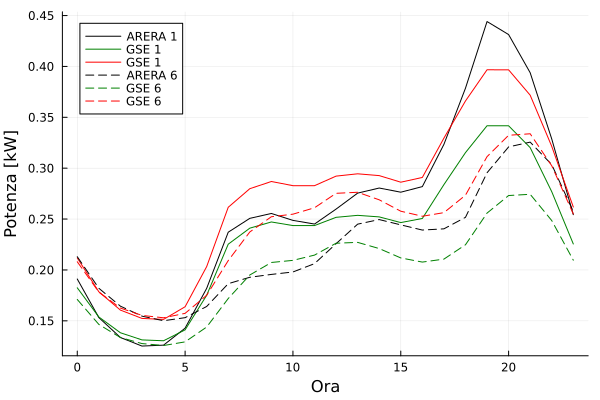

"c:\\Users\\tomma\\OneDrive\\Desktop\\test\\ECPreprocessing\\results\\Immagini\\Comparison_ARERA_GSE_1_3_power.png"

In [4]:
# Show month 1 and month 6 of the new DataFrame
p0 = plot(xlab = "Ora", ylab = "Potenza [kW]", legend = :topleft)

#Selezione dei mesi e del giorno [21 o 22] per il plot
df_selected = df_comparison[((df_comparison.Mese .== 1) .| (df_comparison.Mese .== 6)) .& (df_comparison.Giorno .== 22), :]

# Plotta i dati
for i in unique(df_selected.Mese)
    if i > 5
        line = :dash
    else
        line = :solid
    end
    subset = df_selected[df_selected.Mese .== i, :]
    plot!(p0, subset.Ora, subset.ARERA, label = "ARERA $i", color = :black, line = line)
    plot!(p0, subset.Ora, subset.GSE_1_3_power, label = "GSE $i", color = :green, line = line)
    plot!(p0, subset.Ora, subset.GSE_all_power, label = "GSE $i", color = :red, line = line)
    #plot!(p0, subset.Ora, subset.GSE_all_power_average, label = "GSE $i", color = :purple, line = line)
end

# Mostra il plot
display(p0)

# Salva il plot
savefig(joinpath(general_path,"../results/Immagini/Comparison_ARERA_GSE_1_3_power.png"))

# Data analysis

In [5]:
# Calculate the MAD (mean absolute difference) of the difference between the two profiles
mad1 = mean(abs.(df_comparison[!,"GSE_1_3_power"] .- df_comparison[!,"ARERA"]))
mad2 = mean(abs.(df_comparison[!,"GSE_all_power"] .- df_comparison[!,"ARERA"]))
mad3 = mean(abs.(df_comparison[!,"GSE_all_power_average"] .- df_comparison[!,"ARERA"]))

# Calcola il RMSE tra due vettori x e y
rmse1 = sqrt(mean((df_comparison[!,"GSE_1_3_power"] .- df_comparison[!,"ARERA"]).^2))
rmse2 = sqrt(mean((df_comparison[!,"GSE_all_power"] .- df_comparison[!,"ARERA"]).^2))
rmse3 = sqrt(mean((df_comparison[!,"GSE_all_power_average"] .- df_comparison[!,"ARERA"]).^2))

# Arrotonda i risultati alla quinta cifra decimale e stampali
println("Mean Absolute Difference [kWh]: \n", "GSE 1-3 power: ", round(mad1, digits=5), "\nGSE all power: ", round(mad2, digits=5), "\nGSE all power average: ", round(mad3, digits=5))
println("Root Mean Squared Error [kWh]: \n", "GSE 1-3 power ", round(rmse1, digits=5), "\nGSE all power ", round(rmse2, digits=5), "\nGSE all power average ", round(rmse3, digits=5))


Mean Absolute Difference [kWh]: 
GSE 1-3 power: 0.02241
GSE all power: 0.02203
GSE all power average: 0.03022
Root Mean Squared Error [kWh]: 
GSE 1-3 power 0.02992
GSE all power 0.02781
GSE all power average 0.03759
